In [2]:
### If you haven't yet installed wot, uncomment and run the line below:
#!pip install -q wot

# We begin by importing some useful python packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wot

# Notebook 2: Computing transport matrices

In this notebook we compute transport matrices connecting each pair of time-points, and we examine the effect of each parameter on the solution. 

To compute the transport matrix $\pi_{t_1,t_2}$ connecting cells $x_1, \ldots, x_n$ at time $t_1$ to cells $y_1, \ldots, y_m$ at time $t_2$, we solve an optimization problem over all matrices $\pi$ that obey certain row-sum and column-sum constraints. 
These constraints ensure that the total amount of mass flowing out of each cell $x_i$ and into each cell $y_j$ adds up the correct amount. 
We select the transport matrix with the lowest possible transport cost, subject to these constraints. 

The amount of mass flowing out of each cell $x_i$ depends on the *growth rate* of the cell. We do this in step 1 below, before proceeding to computing transport maps in step 2. 


# Step 1: Construct initial estimate of cell growth rates (optional)
Before computing transport maps, we first form an initial estimate of the cell growth rate function $g(x)$. We do this using signatures of proliferation and apoptosis computed in Notebook 1. Note that we later refine this initial estimate using unbalanced optimal transport, as explained later in this notebook. 

We begin by examining the histograms of these signatures, and we find that the proliferation scores are bimodal. 

(array([1.44000e+02, 2.90400e+03, 5.02590e+04, 1.14705e+05, 5.70960e+04,
        1.81750e+04, 6.19600e+03, 1.47900e+03, 2.16000e+02, 2.90000e+01]),
 array([-0.619866  , -0.45676007, -0.29365414, -0.13054821,  0.03255772,
         0.19566365,  0.35876958,  0.52187551,  0.68498144,  0.84808737,
         1.0111933 ]),
 <a list of 10 Patch objects>)

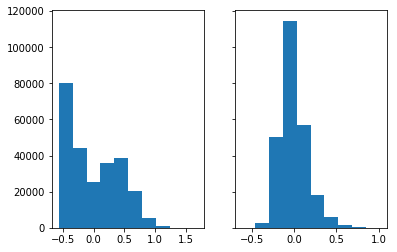

In [3]:
# load proliferation and apoptosis scores
gene_set_scores = pd.read_csv('data/gene_set_scores.csv', index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

# plot histogram of proliferation and apoptosis
fig, axs = plt.subplots(1, 2, sharey=True);
n_bins = 10
axs[0].hist(proliferation, bins=n_bins)
axs[1].hist(apoptosis, bins=n_bins)

We apply a logistic function to transform these two peaks into biologically plausible vaules, in terms of  where the most proliferative cells double every 9 hours, and the least proliferative cells double every 60 hours. 

In [4]:
# apply logistic function to transform to birth rate and death rate

def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)


def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)


def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

def logistic(x, L=1, k=1, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
# g = exp(birth - death)

gr = np.exp(birth-death)
growth_rates_df = pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr})
growth_rates_df.to_csv('data/growth_gs_init.txt')

# Step 2: Compute transport maps

We are now ready to compute transport maps. 

The next code block reads in the expression matrix, cell days, and the initial cell growth rates we computed in step 1 above. If the cell growth rates are not provided, the algorithm will assume each cell grows at roughly the same rate.  Note that the expression matrix we use here contains variable gene expression data of 1,400 genes from two time-course experiments, and we apply a filter to select cells from the serum time course. 

In [5]:
VAR_GENE_DS_PATH = 'data/ExprMatrix.var.genes.loom'
CELL_DAYS_PATH = 'data/cell_days.txt'
SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'

adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, growth_rates_df], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

(175472, 1479)

# The optimization problem

We solve the following *unbalanced transport* optimization problem introduced in Chizat et al 2018, where we only enforce the row-sum constraints approximately and we add entropy to the transport matrix: 

\begin{equation}
\begin{aligned}
\underset{\pi}{\text{minimize}} & \qquad \iint c(x,y) \pi(x,y) dx dy - \epsilon \int \pi(x,y) \log \pi(x,y) dx dy \\
&\qquad + \lambda_2 {\text{KL}} \left ( \int \pi(x,y) dx  \Big \vert d \hat {\mathbb{P}}_{t_2} (y) \int g(x)^{t_2 - t_1} d \hat {\mathbb{P}}_{t_1}(x) \right ) \\ 
& \qquad + \lambda_1 {\text{KL}} \left ( \int \pi(x,y) dy \Big \vert d \hat {\mathbb{P}}_{t_1} (x) g(x)^{t_2 - t_1} \right). 
\end{aligned}
\end{equation}

Here we use the notation  $\hat {\mathbb{P}}_{t_k} = \frac 1 n \sum_{i=1}^n \delta_{x_i}$ for the empirical distribution of samples $x_1,\ldots,x_n$ at time $t_k$.

$\text{KL}(P \vert Q)$ denotes the KL-divergence between distributions $P$ and $Q$. The function $c(x,y)$ encodes the cost of transporting a unit mass from $x$ to $y$. The function $g(x)$ encodes the growth rate of cell $x$, and is used to specify the budget of descendant mass for each cell $x_i$ at time $t_1$. 

(*Add part on Defining transport cost*)

The optimization problem has three regularization parameters: 
* $\epsilon$ controls the degree of entropy in the transport map. 
A larger value gives more entropic descendant distributions, where cells are able to obtain more fates. 
* $\lambda_1$ controls the constraint on the row sums of $\pi_{t_1,t_2}$, which depend on the growth rate function $g(x)$ 
A smaller value of $\lambda_1$ enforces the constraints less strictly, which is useful when we do not have precise information about $g(x)$.
* $\lambda_2$ controls the constraint on the column sums of $\pi_{t_1,t_2}$.


In [6]:
ot_model = wot.ot.OTModel(adata, growth_iters=3) 

# Compute a single transport map from day 7 to 7.5
tmap_adata = ot_model.compute_transport_map(7,7.5)

The object tmap_adata is an annotated transport matrix. 
The actual transport matrix is tmap_adata.X

tmap_adata.obs encodes the cell barcodes at time t0 and tmap_adata.var encodes the cell barcodes at time t1.
Additionally tmap_adata.obs stores the learned growth rates for every growth iteration.

In [7]:
tmap_adata.obs

,g0,g1,g2,g3
id,,,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.268895,0.977585,0.771916,0.620910
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.978660,2.510198,2.130936,1.825271
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.871918,1.789105,1.692332,1.590505
D7_Dox_C1_AAACCTGCACTATCTT-1,3.072989,2.790361,2.516857,2.265156
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.026225,0.918581,0.815133,0.720493
D7_Dox_C1_AAACCTGCATATACGC-1,1.412582,1.366067,1.303659,1.233986
D7_Dox_C1_AAACCTGCATCCGTGG-1,1.182596,1.144584,1.093316,1.033573
D7_Dox_C1_AAACCTGTCGGAATCT-1,0.982687,1.047558,1.093741,1.125473
D7_Dox_C1_AAACGGGGTAGTACCT-1,0.417277,0.443069,0.462440,0.476634


Visualize how growth rates change with growth iterations

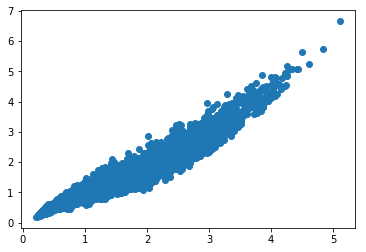

In [8]:
plt.scatter(tmap_adata.obs['g1'],tmap_adata.obs['g2'])
plt.show()

Compute another transport map from day 7.5 to 8

In [9]:
tmap_adata = ot_model.compute_transport_map(7.5, 8)

Compute all transport maps

In [ ]:
ot_model.compute_all_transport_maps(tmap_out='tmaps/serum')